In [1]:
import logging

import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics
from pyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, init_to_mean,init_to_feasible,AutoNormal

In [7]:
pyro.set_rng_seed(10)
import torch.nn.functional as F


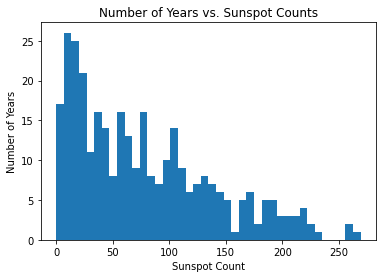

torch.Size([100, 20])
torch.Size([32, 100, 20])
torch.Size([32, 100])
torch.Size([32])
torch.Size([100, 20])
torch.Size([32, 100, 20])
torch.Size([32, 100])
torch.Size([32])
torch.Size([100, 20])
torch.Size([32, 100, 20])
torch.Size([32, 100])
torch.Size([32])
torch.Size([100, 20])
torch.Size([32, 100, 20])
torch.Size([32, 100])
torch.Size([32])


ValueError: Expected parameter concentration (Tensor of shape (20,)) of distribution Gamma(concentration: torch.Size([20]), rate: torch.Size([20])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([ 8.8322,     nan,  2.2224,  1.0802,  8.8056,  1.5653,  0.1600,  3.7947,
         1.6301,  5.3325,  5.1980,  4.9504,  1.2141,  8.8212,  9.0136,  6.3748,
        11.8068,  1.8210,  0.8556,  2.2714], grad_fn=<AddBackward0>)
    Trace Shapes:       
     Param Sites:       
            kappa     19
            tau_0     20
            tau_1     20
              phi 290 20
    Sample Sites:       
  beta_plate dist      |
            value  19  |
        beta dist  19  |
            value  19  |
lambda_plate dist      |
            value  20  |

In [9]:
df = pd.read_csv('http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32).round()
N = data.shape[0]

plt.hist(df['sunspot.year'].values, bins=40)
plt.title("Number of Years vs. Sunspot Counts")
plt.xlabel("Sunspot Count")
plt.ylabel("Number of Years")
plt.show()
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", dist.Beta(1, alpha))

    with pyro.plate("lambda_plate", T):
        lmbda = pyro.sample("lambda", dist.Gamma(3, 0.05))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
        pyro.sample("obs", dist.Poisson(lmbda[z]), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau_0 = pyro.param('tau_0', lambda: dist.Uniform(0, 5).sample([T]), constraint=constraints.positive)
    tau_1 = pyro.param('tau_1', lambda: dist.LogNormal(-1, 1).sample([T]), constraint=constraints.positive)
    phi = pyro.param('phi', lambda: dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("lambda_plate", T):
        q_lambda = pyro.sample("lambda", dist.Gamma(tau_0, tau_1))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(phi))

def train(num_iterations):
    pyro.clear_param_store()
    for j in (range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)
T = 6
alpha = 1.1
n_iter = 1500
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []


def mixture_of_poisson(weights, rates, samples):
    return (weights * dist.Poisson(rates).log_prob(samples.unsqueeze(-1)).exp()).sum(-1)




# Hold out 10% of our original data to test upon
df_test = df.sample(frac=0.1)
data = torch.tensor(df.drop(df_test.index)['sunspot.year'].values, dtype=torch.float).round()
data_test = torch.tensor(df_test['sunspot.year'].values, dtype=torch.float).round()
N = data.shape[0]
N_test = data_test.shape[0]

alphas = [0.05, 0.1, 0.5, 0.75, 0.9, 1., 1.25]
log_predictives = []

for val in alphas:
    alpha = val
    T = 20
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train(500)

    S = 100 # number of Monte Carlo samples to use in posterior predictive computations

    # Using pyro's built in posterior predictive class:
    posterior = Predictive(guide, num_samples=S, return_sites=["beta", "lambda"])(data)
    post_pred_weights = mix_weights(posterior["beta"])
    post_pred_clusters = posterior["lambda"]
    print(post_pred_clusters.shape)

    # log_prob shape = N_test x S
    print(dist.Poisson(post_pred_clusters).log_prob(data_test.reshape(-1, 1, 1)).shape)
    log_prob = (post_pred_weights.log() + dist.Poisson(post_pred_clusters).log_prob(data_test.reshape(-1, 1, 1))).logsumexp(-1)
    print(log_prob.shape)
    mean_log_prob = log_prob.logsumexp(-1) - np.log(S)
    print(mean_log_prob.shape)
    log_posterior_predictive = mean_log_prob.sum(-1)
    log_predictives.append(log_posterior_predictive)

plt.figure(figsize=(10, 5))
plt.plot(alphas, log_predictives)
plt.title("Value of the Log Predictive at Varying Alpha")
plt.show()

In [3]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)

(1127, 5237)


In [3]:
class PMF_Bayesian(nn.Module):

    #with multivariate gammas that are "somehow?" related through pyro's dependent dimension setting
    #how to define their covariance?
    def __init__(self, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = train.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()

        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
       
        self.bias = self.data.mean()


    def model(self,  train):

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim,self.n]).to_event(2))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        
        VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim,self.m]).to_event(2))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
            Y = pyro.sample("target", dist.Poisson(UA.T@VA), obs = train) 
            return Y
            
    def guide(self, train=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.dim,self.n), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.dim,self.n), constraint=constraints.positive)
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        s_alpha = pyro.param('s_alpha', torch.ones(self.dim,self.m), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones (self.dim,self.m), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items)

       
        UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(2))
           # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
        
        VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(2))

    
    def train_SVI(self,train, nsteps=250, lr = 0.01, lrd = 1):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float())
            losses.append(elbo)
            if step % 10 == 0:
                print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
        mc_table[mc_table < self.bounds[1]] = self.bounds[0]
        mc_table[mc_table >= self.bounds[1]] = self.bounds[1]
        self.predictions = mc_table
        
    
    def rmse(self,test):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < high] = low
        test_data[test_data >= high] = high
        sqerror = abs(test_data - self.predictions) ** 2  # squared error array
        mse = sqerror.sum()/(test_data.shape[0]*test_data.shape[1])
        print("PMF MAP training RMSE: %.5f" % np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data.astype(int).flatten(),  self.predictions.astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return self.predictions


In [11]:
test = PMF_Bayesian(train=data, dim=100)
test.train_SVI(data)



Elbo loss: 15783411.265625
Elbo loss: 15663015.265625
Elbo loss: 16145332.765625
Elbo loss: 15826587.921875
Elbo loss: 15719802.25
Elbo loss: 15592114.84375
Elbo loss: 16002269.5625
Elbo loss: 15610041.640625
Elbo loss: 15560336.8125
Elbo loss: 15778299.484375
Elbo loss: 15540349.015625
Elbo loss: 15444293.75
Elbo loss: 15495942.046875
Elbo loss: 15487900.578125
Elbo loss: 15396425.5
Elbo loss: 15226229.21875
Elbo loss: 15339010.9375
Elbo loss: 15327952.0
Elbo loss: 15188313.953125
Elbo loss: 15354570.0
Elbo loss: 15365459.0625
Elbo loss: 15043918.90625
Elbo loss: 15205022.578125
Elbo loss: 15365884.71875
Elbo loss: 15196678.84375


[15783411.265625,
 15982159.515625,
 15858975.078125,
 15929883.609375,
 16119493.796875,
 15810800.484375,
 16048108.4375,
 15962100.484375,
 15937342.078125,
 15806775.75,
 15663015.265625,
 15990829.375,
 15851723.671875,
 15867087.625,
 15815056.046875,
 15978717.75,
 15919643.703125,
 15788299.546875,
 15660207.359375,
 15762928.828125,
 16145332.765625,
 15920802.90625,
 16016311.21875,
 15984159.96875,
 15796621.125,
 15644638.65625,
 15806779.578125,
 15928478.21875,
 15983178.71875,
 15844046.15625,
 15826587.921875,
 15793722.109375,
 15708210.421875,
 15622728.5625,
 15751240.828125,
 15913168.875,
 15851111.0625,
 15580053.75,
 15758030.65625,
 15696492.1875,
 15719802.25,
 15613640.3125,
 15740376.546875,
 15998692.515625,
 15668583.15625,
 15841526.90625,
 15768233.75,
 15596485.8125,
 15699927.5,
 15769493.234375,
 15592114.84375,
 15720412.875,
 15645728.109375,
 15468635.5,
 15542452.796875,
 15514051.15625,
 15546926.09375,
 15690490.90625,
 15488243.84375,
 15644363.

In [12]:
test.sample_predict(1000)
test.rmse(data)
print(test.get_predictions())
print(data)

UA: (1000, 1, 1, 100, 1127)
VA: (1000, 1, 1, 100, 5237)
target: (1000, 1127, 5237)
PMF MAP training RMSE: 0.36233
AUC: 0.84131
[[1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 1  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  1  8  0]
 ...
 [ 8  0  0 ... 10 12  0]
 [ 1  0  0 ...  4 25  0]
 [ 0  0  0 ...  0  0  0]]


In [13]:
test.rmse(data)

PMF MAP training RMSE: 0.36233
AUC: 0.84131


(0.36233013243166723, 0.841312632158804)

In [10]:
class PMF_Bayesian2(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = train.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()

        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
       
        self.bias = self.data.mean()


    def model(self,train):
            m_10 = torch.zeros(self.n)
            cov_w1 = torch.eye(self.n)
            cov_1 = pyro.sample("cov1", dist.Wishart(covariance_matrix= cov_w1, df = torch.Tensor([2*self.n])))
            mu_1 = pyro.sample("mu_1", dist.MultivariateNormal(m_10, precision_matrix = cov_1))
            m_20 = torch.zeros(self.m)
            cov_w2 = torch.eye(self.m)
            cov_2 = pyro.sample("cov2", dist.Wishart(covariance_matrix= cov_w2, df = torch.Tensor([2*self.m])))
            mu_2 = pyro.sample("mu_2", dist.MultivariateNormal(m_20, precision_matrix = cov_2))
            print(torch.det(cov_1))

            
            drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
            sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

            UA = pyro.sample("UA", dist.MultivariateNormal(mu_1, precision_matrix= cov_1))
                #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
            
            
            VA = pyro.sample("VA", dist.MultivariateNormal(mu_2, precision_matrix =cov_2))
                #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
        
            u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

            with sideeffect_plate, u2_plate: 
                Y = pyro.sample("target", dist.Poisson(torch.abs(UA.T@VA)), obs = train) 
                return Y

    def guide( self,train=None, mask=None):

            mu_10= pyro.param('mu_10', torch.zeros(self.n))#*self.user_mean)
            cov_w1 = pyro.param('d_beta', 3*torch.eye(self.n), constraint=constraints.positive_definite)
            mu_20= pyro.param('s_alpha', torch.zeros(self.m))
            cov_w2 = pyro.param('s_beta', 3*torch.eye(self.m), constraint=constraints.positive_definite)
            cov_1 = pyro.sample("cov1", dist.Wishart(covariance_matrix= cov_w1, df = torch.Tensor([self.n])))
            cov_2 = pyro.sample("cov2", dist.Wishart(covariance_matrix= cov_w2, df = torch.Tensor([self.m])))
            mu_1 = pyro.sample("mu_1", dist.MultivariateNormal(mu_10, precision_matrix = cov_1))
            mu_2 =  pyro.sample("mu_2", dist.MultivariateNormal(mu_20, precision_matrix = cov_2))


            UA =  pyro.sample("UA", dist.MultivariateNormal(mu_1, precision_matrix= cov_1))
            # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
            
            VA = pyro.sample("VA", dist.MultivariateNormal(mu_2, precision_matrix =  cov_2))

    
    def train_SVI(self,train, nsteps=25, lr = 0.01, lrd = 1):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
         AutoNormal(self.model, init_loc_fn=init_to_feasible),#self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float())
            losses.append(elbo)
            if step % 10 == 0:
                print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)( None)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
        mc_table[mc_table < self.bounds[1]] = self.bounds[0]
        mc_table[mc_table >= self.bounds[1]] = self.bounds[1]
        self.predictions = mc_table
        
    
    def rmse(self,test):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < high] = low
        test_data[test_data >= high] = high
        sqerror = abs(test_data - self.predictions) ** 2  # squared error array
        mse = sqerror.sum()/(test_data.shape[0]*test_data.shape[1])
        print("PMF MAP training RMSE: %.5f" % np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data.astype(int).flatten(),  self.predictions.astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return self.predictions


In [11]:

# test2.train_SVI(data2)
# test2.sample_predict(500)
# test2.rmse(data2)
# print(test2.get_predictions())
# print(data2)


Warmup:   0%|          | 0/1000 [00:00, ?it/s]

tensor([inf])


_LinAlgError: torch.linalg_cholesky: (Batch element 0): The factorization could not be completed because the input is not positive-definite (the leading minor of order 1050 is not positive-definite).
Trace Shapes:              
 Param Sites:              
Sample Sites:              
    cov1 dist 1 | 1127 1127
        value 1 | 1127 1127

In [7]:
#Testing!!!

n,m = data.shape
dim=10
mean_u = 4
mean_v=5
std_v=1
std_u=1
dim=10
alpha_u = 4
alpha_v=5
beta_u=1
beta_v=1
m=3000
drug_code = np.arange(n)
se_code =np.arange(m)
def model():
        m_10 = torch.zeros(n)
        cov_w1 = torch.eye(n)
        cov_1 = pyro.sample("cov1", dist.Wishart(scale_tril= cov_w1, df = torch.Tensor([2*n])))
        mu_1 = pyro.sample("mu_1", dist.MultivariateNormal(m_10, precision_matrix = cov_1))
        m_20 = torch.zeros(m)
        cov_w2 = torch.eye(m)
        cov_2 = pyro.sample("cov2", dist.Wishart(scale_tril= cov_w2, df = torch.Tensor([2*m])))
        mu_2 = pyro.sample("mu_2", dist.MultivariateNormal(m_20, precision_matrix = cov_2))
        print(cov_1)

        
        drug_plate = pyro.plate("drug_latents", n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", m, dim= -1) #independent items

        UA = pyro.sample("UA", dist.MultivariateNormal(mu_1, cov_1))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        
        VA = pyro.sample("VA", dist.MultivariateNormal(mu_2, cov_2))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", n, dim=-2)

        with sideeffect_plate, u2_plate: 
            Y = pyro.sample("target", dist.Poisson(torch.abs(UA.T@VA))) 
            return Y

def guide( train=None, mask=None):

        mu_1= pyro.param('d_alpha', torch.zeros(n))#*self.user_mean)
        cov_w1 = pyro.param('d_beta', torch.eye(n), constraint=constraints.positive)
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        mu_2= pyro.param('s_alpha', torch.zeros(m))
        cov_w2 = pyro.param('s_beta', torch.eye(m), constraint=constraints.positive)
        
        cov_1 = pyro.sample("cov1", dist.Wishart(scale_tril= cov_w1, df = torch.Tensor([2*n])))
        cov_2 = pyro.sample("cov2", dist.Wishart(scale_tril= cov_w2, df = torch.Tensor([2*m])))


        UA =  pyro.sample("UA", dist.MultivariateNormal(mu_1, cov_1))
           # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
        
        VA = pyro.sample("VA", dist.MultivariateNormal(mu_2, cov_2))


        

In [8]:


trace=poutine.trace(guide).get_trace()
trace.compute_log_prob()
print(trace.format_shapes())

trace=poutine.trace(model).get_trace()
trace.compute_log_prob()
print(trace.format_shapes())

Trace Shapes:                    
 Param Sites:                    
      d_alpha      1127          
       d_beta 1127 1127          
      s_alpha      2800          
       s_beta 2800 2800          
Sample Sites:                    
    cov1 dist    1    | 1127 1127
        value    1    | 1127 1127
     log_prob    1    |          
    cov2 dist    1    | 2800 2800
        value    1    | 2800 2800
     log_prob    1    |          
      UA dist    1    | 1127     
        value    1    | 1127     
     log_prob    1    |          
      VA dist    1    | 2800     
        value    1    | 2800     
     log_prob    1    |          
tensor([[[ 2.2811e+03,  1.6974e+01,  1.2097e+01,  ..., -9.2563e+01,
          -8.4243e+00, -5.2117e+01],
         [ 1.6974e+01,  2.2396e+03, -3.9046e+01,  ..., -1.7212e-01,
          -1.8317e+01, -2.2925e+01],
         [ 1.2097e+01, -3.9046e+01,  2.4201e+03,  ...,  7.1174e+01,
           6.4328e+01,  5.0572e+00],
         ...,
         [-9.2563e+01, -1

In [4]:

class PMF_clusters2(nn.Module):
    #bayesian non parametrics - dirichlet process

    #with multivariate gammas that are "somehow?" related through pyro's dependent dimension setting
    #how to define their covariance?
    def __init__(self, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = train.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()

        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
       
        self.bias = self.data.mean()
        self.num_clusters_drugs = 1000
        self.num_clusters_se =  5000
    def mix_weights(self,beta):
            beta1m_cumprod = (1 - beta).cumprod(-1)
            return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

    def model(self, data):
            alpha = 0.1
            with pyro.plate("beta_drugs_plate", self.num_clusters_drugs-1):
                beta_drugs = pyro.sample("beta_drugs", dist.Beta(1, alpha))

            with pyro.plate("mu_drugs_plate", self.num_clusters_drugs):
                mu_drugs = pyro.sample("mu_drugs", dist.MultivariateNormal(torch.zeros(self.dim), 0.5 * torch.eye(self.dim)))
                theta = pyro.sample("theta", dist.HalfCauchy(torch.ones(self.dim)))
                # Lower cholesky factor of a correlation matrix
                concentration = torch.ones(
                    (),
                )  # Implies a uniform distribution over correlation matrices
                L_omega = pyro.sample("L_omega", dist.LKJCholesky(self.dim, concentration))
            # Lower cholesky factor of the covariance matrix
                L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)
    # For inference with SVI, one might prefer to use torch.bmm(theta.sqrt().diag_embed(), L_omega)
            with pyro.plate("data_drugs", self.n):
                z_d = pyro.sample("z_drugs", dist.Categorical(self.mix_weights(beta_drugs)))
                UA = pyro.sample("UA", dist.MultivariateNormal(mu_drugs[z_d], scale_tril=L_Omega))

            with pyro.plate("beta_se_plate", self.num_clusters_se-1):
                beta_se = pyro.sample("beta_se", dist.Beta(1, alpha))

            with pyro.plate("mu_plate_se", self.num_clusters_se):
                mu_se = pyro.sample("mu_se", dist.MultivariateNormal(torch.zeros(self.dim), 0.5 * torch.eye(self.dim)))

            with pyro.plate("data_sideeffects", self.m):
                z_se = pyro.sample("z_se", dist.Categorical(self.mix_weights(beta_se)))
                VA = pyro.sample("VA", dist.MultivariateNormal(mu_se[z_se], torch.eye(self.dim)))
            
            u2_plate = pyro.plate("u2_plate", self.n, dim=-2)
            se2_plate = pyro.plate("se2_plate", self.m, dim=-1)

            with se2_plate, u2_plate: 
                Y = pyro.sample("target", dist.Poisson(torch.abs(UA@VA.T)), obs=data ) 
                return Y

    def guide(self,data=None):
            kappa = pyro.param('kappa_d', lambda: dist.Uniform(0, 2).sample([self.num_clusters_drugs-1]), constraint=constraints.positive)
            tau = pyro.param('tau_d', lambda: dist.MultivariateNormal(torch.zeros(self.dim), 0.5 * torch.eye(self.dim)).sample([self.num_clusters_drugs]))
            phi = pyro.param('phi_d', lambda: dist.Dirichlet(1/self.num_clusters_drugs * torch.ones(self.num_clusters_drugs)).sample([self.n]), constraint=constraints.simplex)
            cov1 = pyro.param('cov_1',lambda: dist.HalfCauchy( 1*torch.ones(self.dim)).sample([self.num_clusters_drugs]), constraint=constraints.positive)

            with pyro.plate("beta_plate", self.num_clusters_drugs-1):
                beta_drugs = pyro.sample("beta_drugs", dist.Beta(torch.ones(self.num_clusters_drugs-1), kappa))

            with pyro.plate("mu_plate_drug", self.num_clusters_drugs):
                mu_drugs = pyro.sample("mu_drugs", dist.MultivariateNormal(tau, torch.eye(self.dim)))
                theta = pyro.sample("theta", dist.HalfCauchy(cov1))
                # Lower cholesky factor of a correlation matrix
                concentration = torch.ones(
                    (),
                )  # Implies a uniform distribution over correlation matrices
                L_omega = pyro.sample("L_omega", dist.LKJCholesky(self.dim, concentration))
            # Lower cholesky factor of the covariance matrix
                L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)

            with pyro.plate("data_drug", self.n):
                z_d = pyro.sample("z_drugs", dist.Categorical(phi))
                UA = pyro.sample("UA", dist.MultivariateNormal(mu_drugs[z_d],scale_tril= L_Omega[z_d]))

            
            kappa_s = pyro.param('kappa_s', lambda: dist.Uniform(0, 2).sample([self.num_clusters_se-1]), constraint=constraints.positive)
            tau_s = pyro.param('tau_s', lambda: dist.MultivariateNormal(torch.zeros(self.dim), 0.5 * torch.eye(self.dim)).sample([self.num_clusters_se]))
            phi_s = pyro.param('phi_s', lambda: dist.Dirichlet(1/self.num_clusters_se * torch.ones(self.num_clusters_se)).sample([self.m]), constraint=constraints.simplex)

            with pyro.plate("beta_se_plate", self.num_clusters_se-1):
                beta_se = pyro.sample("beta_se", dist.Beta(torch.ones(self.num_clusters_se-1), kappa_s))

            with pyro.plate("mu_plate_se", self.num_clusters_se):
                mu_se = pyro.sample("mu_se", dist.MultivariateNormal(tau_s, torch.eye(self.dim)))

            with pyro.plate("data_sideeffects", self.m):
                z_se = pyro.sample("z_se", dist.Categorical(phi_s))
                VA = pyro.sample("VA", dist.MultivariateNormal(mu_se[z_se], torch.eye(self.dim)))

    def train_SVI(self,train, nsteps=250, lr = 0.05, lrd = 1):
                logging.basicConfig(format='%(message)s', level=logging.INFO)
                svi = SVI(self.model,
                self.guide,
                optim.ClippedAdam({"lr": lr, "lrd": lrd}),
                loss=Trace_ELBO())
                losses = []
                for step in range(nsteps):
                    elbo = svi.step(torch.from_numpy(train).float())
                    losses.append(elbo)
                    if step % 10 == 0:
                        print("Elbo loss: {}".format(elbo))
                self.losses = losses
                #constrained_params = list(pyro.get_param_store().values())
                #PARAMS = [p.unconstrained() for p in constrained_params]
                #print(PARAMS)
                return losses

In [5]:
test = PMF_clusters2(train=data, dim=99)
test.train_SVI(data)

ValueError: Shape mismatch inside plate('mu_plate_drug') at site theta dim -1, 1000 vs 99
     Trace Shapes:             
      Param Sites:             
           kappa_d       999   
             tau_d 1000   99   
             phi_d 1127 1000   
             cov_1 1000   99   
     Sample Sites:             
   beta_plate dist         |   
             value  999    |   
   beta_drugs dist  999    |   
             value  999    |   
mu_plate_drug dist         |   
             value 1000    |   
     mu_drugs dist 1000    | 99
             value 1000    | 99